In [35]:
# take 10% of images from each class to validation

In [36]:
# there are B&W images in data!

In [37]:
import os
from datetime import datetime
from typing import Tuple
from time import monotonic

from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset

import torch
from torch import nn

from torch import optim
import torch.nn.functional as F

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

### Data

In [38]:
class TinyImageNetDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 annotations: list[Tuple[str, str]],
                 transform=None, 
                 target_transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        file_name, label = self.annotations[idx]
        img_path = os.path.join(self.img_dir, label, 'images', file_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [39]:
# TEMP. check with data
source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'
from pathlib import Path
img_dir = Path(source_folder)
img_dir.exists()
# for c in img_dir.iterdir():
    # for f in (c / "images").iterdir():
        # print(f)
        # break
    # break

# for class_name in img_dir.iterdir():
    # print(len(list((class_name / "images").iterdir())))


# 

True

In [40]:
# for debugging - will remove
N_CLASSES_TO_USE = 200

source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'

train_split = []
val_split = []

# TODO ? maybe use cross-validation somehow? Looks like model will never train on last 50 images. Or it is okay?
class_names = os.listdir(source_folder)
for class_name in class_names[:N_CLASSES_TO_USE]:
    file_names = os.listdir(f'{source_folder}/{class_name}/images')
    file_ids = [int(name.split('.')[0].split('_')[1]) for name in file_names]

    train_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] < 450]
    val_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] >= 450]
    # print(f"val_names:{val_names}")

    train_split.extend((name, class_name) for name in train_names)
    val_split.extend((name, class_name) for name in val_names)

In [ ]:
# print(train_split)
# print(train_split[0])
# print(len(train_split), len(val_split))

90000 10000


In [42]:
# TODO ? why and what we are doing by T.Normalize
train_img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

val_img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# TODO ? why do we need dict with IDs and back
class_name_to_id_dict = {name: i for i, name in enumerate(class_names)}
class_id_to_name_dict = {i: name for name, i in class_name_to_id_dict.items()}

label_to_id_transform = lambda name: class_name_to_id_dict[name]

In [43]:
train_dataset = TinyImageNetDataset(source_folder,
                                    train_split,
                                    transform=train_img_transform,
                                    target_transform=label_to_id_transform
                                    )

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [44]:
# TODO ? do we need also to shuffle the val dataset?
val_dataset = TinyImageNetDataset(source_folder,
                                  val_split,
                                  transform=val_img_transform,
                                  target_transform=label_to_id_transform
                                    )

val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [45]:
# TODO ? what is Y here? why it is 128 values. It should be class value, no?
X, Y = next(iter(train_dataloader))
X.shape, Y.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

---

### Model

In [46]:
# TODO ? just fun, why 42?
def set_seed(seed: int = 42) -> None:
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [47]:
class CnnBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, *args, n_conv_layers = 1):
    super().__init__()

    layers = [
        nn.Conv2d(in_channels,
                  out_channels,
                  kernel_size=kernel_size,
                  padding=kernel_size // 2),
        nn.ReLU()
    ]

    for _ in range(n_conv_layers - 1):
        layers.append(nn.Conv2d(out_channels,
                                out_channels,
                                kernel_size=kernel_size,
                                padding=kernel_size // 2))
        layers.append(nn.ReLU())

    self.conv_layers = nn.Sequential(*layers)
    self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.pool(x)
    return x


class FcBlock(nn.Module):
    def __init__(self, in_shape: int, 
                 out_shape: int, 
                 do_batchnorm: bool = True, 
                 activation: nn.Module = None):
        super().__init__()
        layers = []

        if do_batchnorm:
            layers.append(nn.BatchNorm1d(in_shape))

        layers.append(nn.Linear(in_shape, out_shape))

        if activation is not None:
            layers.append(activation)
            
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [48]:
# 3x64x64 -> (conv1) -> 32x32x32 -> (conv2) -> 64x16x16 -> (conv3) -> 128x8x8 -> (conv4) -> 64x4x4=1024

In [49]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CnnBlock(3, 32, kernel_size=5)
        self.conv2 = CnnBlock(32, 64, kernel_size=5)
        self.conv3 = CnnBlock(64, 128, kernel_size=3)
        self.conv4 = CnnBlock(128, 64, kernel_size=3)

        self.drop1 = nn.Dropout(p=0.2)
        self.fc1 = FcBlock(64 * 4 * 4, 512, do_batchnorm=True, activation=nn.ReLU())
        
        self.drop2 = nn.Dropout(p=0.1)
        self.fc2 = FcBlock(512, 200, do_batchnorm=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = torch.flatten(x, 1)

        x = self.drop1(x)
        x = self.fc1(x)

        x = self.drop2(x)
        x = self.fc2(x)
        return x

In [50]:
model = BaselineModel()

out = model(X)
out.shape

torch.Size([128, 200])

---

### Train

In [51]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [52]:
set_seed(123)

model = BaselineModel()
model.to(DEVICE)

Random seed set as 123


BaselineModel(
  (conv1): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop1

In [53]:
train_config = {
    'n_epochs': 25,
    'lr': 0.005,
    'batch_size': 128,
}

optimizer = optim.Adam(model.parameters(), lr=train_config['lr'])
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

best_checkpoint_path = '../working/best.pth'

In [54]:
def do_train_epoch(model: nn.Module, 
                   criterion: nn.Module,
                   optimizer,
                   train_loader: DataLoader, 
                   verbose: int = -1) -> Tuple[float, float]:
    total_steps = len(train_dataloader)
    
    running_loss, step = 0, 0
    n_correct_predictions, total_predictions = 0, 0
    for X, Y in train_loader:
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        optimizer.zero_grad()
    
        preds = model(X).cuda()
        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        step += 1

        if verbose > 0 and step % verbose == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps}: train loss = {round(running_loss / step, 5)}")

        total_predictions += len(Y)

        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)
        n_correct_predictions += (predicted_labels == Y).sum().item()
    
    avg_loss = round(running_loss / step, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)
    
    return avg_loss, accuracy

In [55]:
def do_val_epoch(model: nn.Module,
                 criterion: nn.Module,
                 val_loader: DataLoader) -> Tuple[float, float]:
    total_steps = len(val_loader)
    
    running_loss = 0
    n_correct_predictions, total_predictions = 0, 0
    
    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            preds = model(X).cuda()
            loss = criterion(preds, Y)
    
            running_loss += loss.item()
            total_predictions += len(Y)
    
            probs = F.softmax(preds, dim=1)
            predicted_labels = torch.argmax(probs, dim=1)
            n_correct_predictions += (predicted_labels == Y).sum().item()

    avg_loss = round(running_loss / total_steps, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)

    print(f'VALIDATION LOSS = {avg_loss}, VALIDATION ACCURACY = {accuracy}')
    
    return avg_loss, accuracy
          

In [56]:
def plot_history(history: dict):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(history['train_loss'], marker='o', label='Train Loss')
    ax[0].plot(history['test_loss'], marker='o', label='Test Loss')
    ax[0].set_title('Loss per epoch')
    ax[0].legend()
    
    ax[1].plot(history['train_accuracy'], marker='o', label='Train Accuracy')
    ax[1].plot(history['test_accuracy'], marker='o', label='Test Accuracy')
    ax[1].set_title('Accuracy per epoch')
    ax[1].legend()
    
    plt.show()


 		 ------------------------------ EPOCH: 1 ------------------------------
[20:02:23] Step 20/704: train loss = 5.57893
[20:02:24] Step 40/704: train loss = 5.53691
[20:02:25] Step 60/704: train loss = 5.48707
[20:02:26] Step 80/704: train loss = 5.42958
[20:02:27] Step 100/704: train loss = 5.38124
[20:02:28] Step 120/704: train loss = 5.33398
[20:02:29] Step 140/704: train loss = 5.28956
[20:02:30] Step 160/704: train loss = 5.24496
[20:02:31] Step 180/704: train loss = 5.19456
[20:02:32] Step 200/704: train loss = 5.15861
[20:02:33] Step 220/704: train loss = 5.12344
[20:02:34] Step 240/704: train loss = 5.08847
[20:02:35] Step 260/704: train loss = 5.05524
[20:02:36] Step 280/704: train loss = 5.01999
[20:02:37] Step 300/704: train loss = 4.98856
[20:02:38] Step 320/704: train loss = 4.96261
[20:02:39] Step 340/704: train loss = 4.93391
[20:02:40] Step 360/704: train loss = 4.9069
[20:02:41] Step 380/704: train loss = 4.8782
[20:02:42] Step 400/704: train loss = 4.85312
[20:02:43]

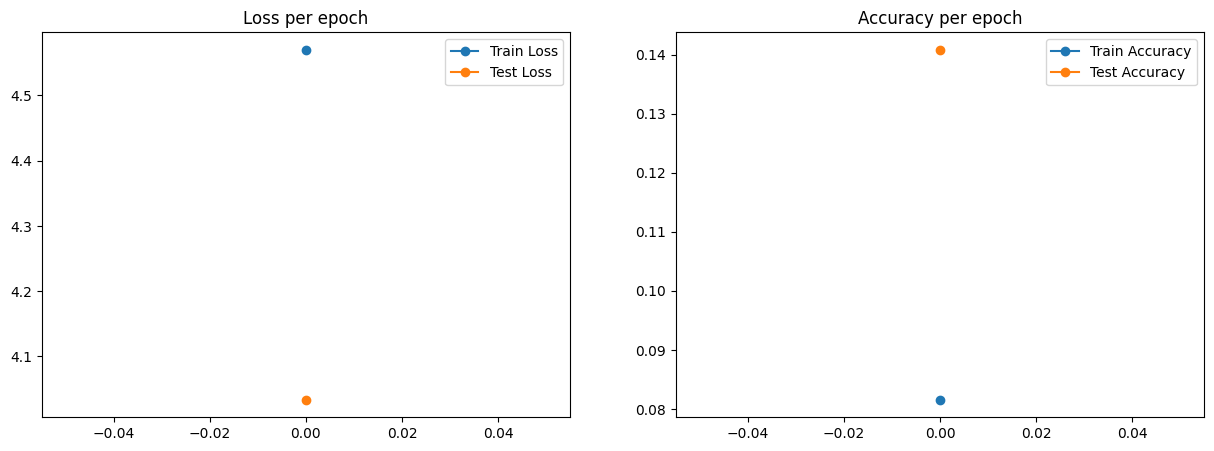

Saving best model

 		 ------------------------------ EPOCH: 2 ------------------------------
[20:03:02] Step 20/704: train loss = 3.97196
[20:03:03] Step 40/704: train loss = 3.97723
[20:03:04] Step 60/704: train loss = 3.96513
[20:03:05] Step 80/704: train loss = 3.945
[20:03:06] Step 100/704: train loss = 3.94545
[20:03:07] Step 120/704: train loss = 3.93716
[20:03:08] Step 140/704: train loss = 3.94035
[20:03:09] Step 160/704: train loss = 3.9281
[20:03:10] Step 180/704: train loss = 3.92112
[20:03:11] Step 200/704: train loss = 3.91987
[20:03:12] Step 220/704: train loss = 3.91898
[20:03:13] Step 240/704: train loss = 3.90997
[20:03:14] Step 260/704: train loss = 3.90138
[20:03:15] Step 280/704: train loss = 3.89526
[20:03:16] Step 300/704: train loss = 3.89325
[20:03:17] Step 320/704: train loss = 3.88884
[20:03:18] Step 340/704: train loss = 3.883
[20:03:19] Step 360/704: train loss = 3.8763
[20:03:20] Step 380/704: train loss = 3.86779
[20:03:21] Step 400/704: train loss = 3.86

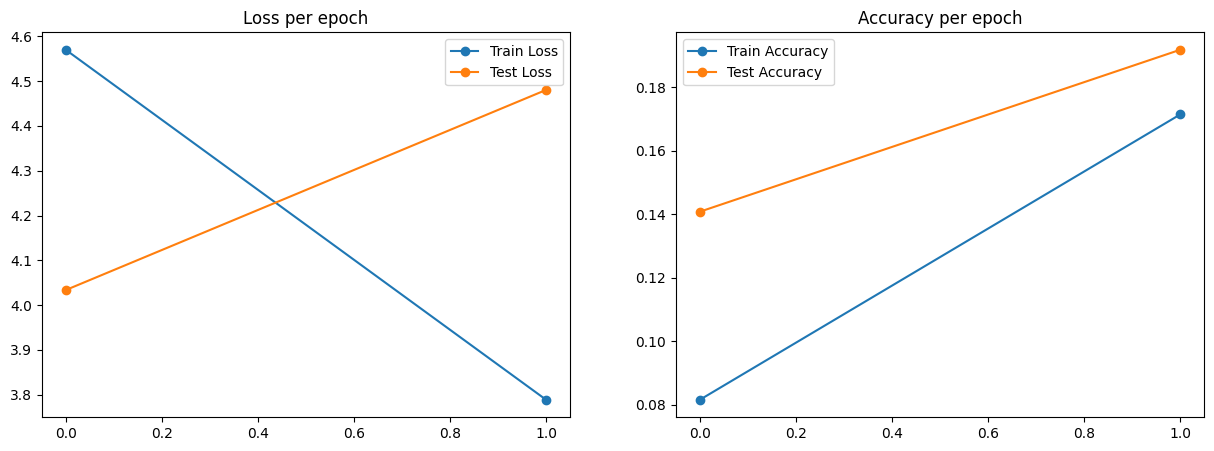

Validation loss didn't improve

 		 ------------------------------ EPOCH: 3 ------------------------------
[20:03:41] Step 20/704: train loss = 3.56802
[20:03:42] Step 40/704: train loss = 3.5029
[20:03:43] Step 60/704: train loss = 3.5086
[20:03:44] Step 80/704: train loss = 3.48244
[20:03:45] Step 100/704: train loss = 3.47606
[20:03:46] Step 120/704: train loss = 3.48298
[20:03:47] Step 140/704: train loss = 3.49479
[20:03:48] Step 160/704: train loss = 3.48211
[20:03:49] Step 180/704: train loss = 3.48334
[20:03:50] Step 200/704: train loss = 3.48971
[20:03:51] Step 220/704: train loss = 3.49313
[20:03:52] Step 240/704: train loss = 3.49587
[20:03:53] Step 260/704: train loss = 3.49399
[20:03:54] Step 280/704: train loss = 3.49786
[20:03:55] Step 300/704: train loss = 3.494
[20:03:56] Step 320/704: train loss = 3.49541
[20:03:57] Step 340/704: train loss = 3.49482
[20:03:58] Step 360/704: train loss = 3.4918
[20:03:59] Step 380/704: train loss = 3.49014
[20:04:00] Step 400/704: tra

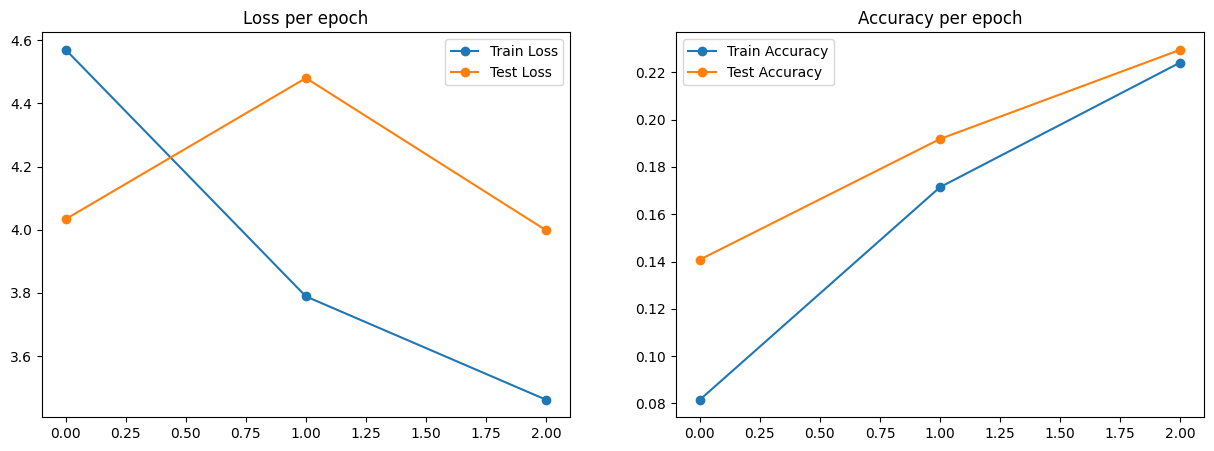

Saving best model

 		 ------------------------------ EPOCH: 4 ------------------------------
[20:04:20] Step 20/704: train loss = 3.50781
[20:04:21] Step 40/704: train loss = 3.71616
[20:04:22] Step 60/704: train loss = 3.69145
[20:04:23] Step 80/704: train loss = 3.64859
[20:04:24] Step 100/704: train loss = 3.61233
[20:04:25] Step 120/704: train loss = 3.57603
[20:04:26] Step 140/704: train loss = 3.54346
[20:04:27] Step 160/704: train loss = 3.52356
[20:04:28] Step 180/704: train loss = 3.5015
[20:04:29] Step 200/704: train loss = 3.48872
[20:04:30] Step 220/704: train loss = 3.47964
[20:04:31] Step 240/704: train loss = 3.46947
[20:04:32] Step 260/704: train loss = 3.45821
[20:04:33] Step 280/704: train loss = 3.4494
[20:04:34] Step 300/704: train loss = 3.43913
[20:04:35] Step 320/704: train loss = 3.43326
[20:04:36] Step 340/704: train loss = 3.42501
[20:04:37] Step 360/704: train loss = 3.41717
[20:04:38] Step 380/704: train loss = 3.41078
[20:04:39] Step 400/704: train loss = 

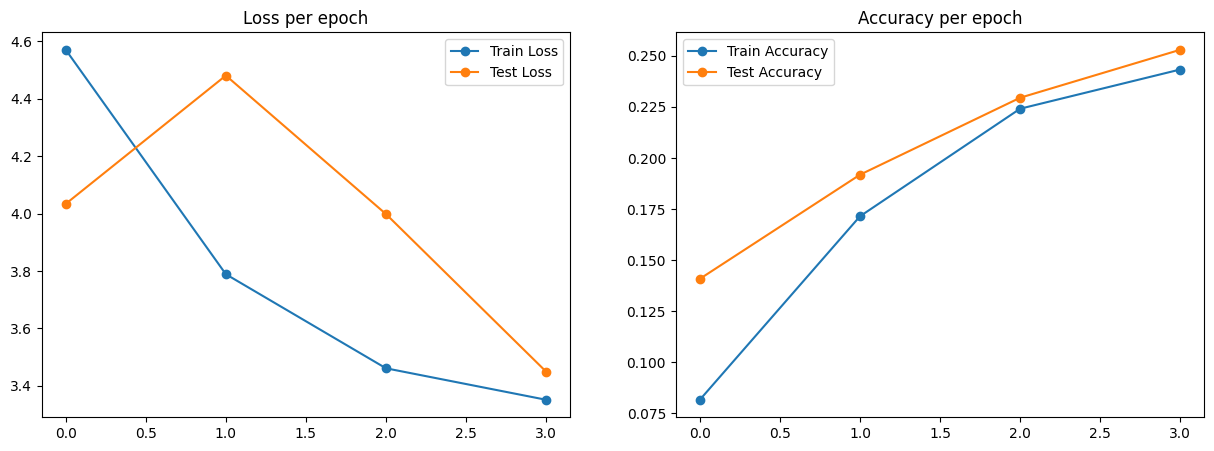

Saving best model

 		 ------------------------------ EPOCH: 5 ------------------------------
[20:04:59] Step 20/704: train loss = 3.1308
[20:05:00] Step 40/704: train loss = 3.08029
[20:05:01] Step 60/704: train loss = 3.08106
[20:05:02] Step 80/704: train loss = 3.08402
[20:05:03] Step 100/704: train loss = 3.08941
[20:05:04] Step 120/704: train loss = 3.09404
[20:05:05] Step 140/704: train loss = 3.09203
[20:05:06] Step 160/704: train loss = 3.09807
[20:05:07] Step 180/704: train loss = 3.1012
[20:05:08] Step 200/704: train loss = 3.09919
[20:05:09] Step 220/704: train loss = 3.09572
[20:05:10] Step 240/704: train loss = 3.09613
[20:05:11] Step 260/704: train loss = 3.09656
[20:05:12] Step 280/704: train loss = 3.09527
[20:05:13] Step 300/704: train loss = 3.09712
[20:05:14] Step 320/704: train loss = 3.09916
[20:05:15] Step 340/704: train loss = 3.09926
[20:05:16] Step 360/704: train loss = 3.09695
[20:05:17] Step 380/704: train loss = 3.0982
[20:05:18] Step 400/704: train loss = 3

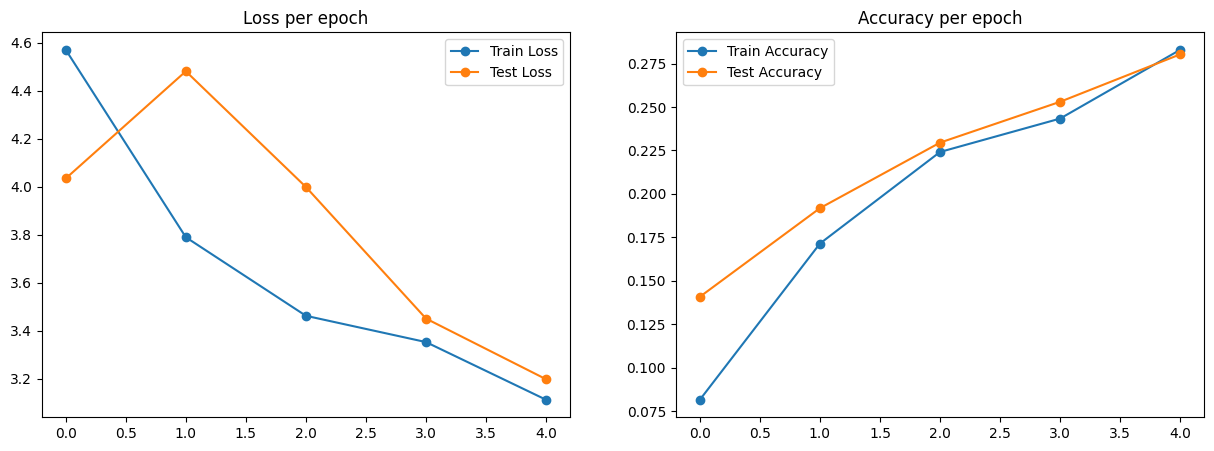

Saving best model

 		 ------------------------------ EPOCH: 6 ------------------------------
[20:05:39] Step 20/704: train loss = 2.83978
[20:05:40] Step 40/704: train loss = 2.80917
[20:05:41] Step 60/704: train loss = 2.81197
[20:05:42] Step 80/704: train loss = 2.82902
[20:05:43] Step 100/704: train loss = 2.83958
[20:05:44] Step 120/704: train loss = 2.8698
[20:05:45] Step 140/704: train loss = 2.87279
[20:05:46] Step 160/704: train loss = 2.8755
[20:05:47] Step 180/704: train loss = 2.87521
[20:05:48] Step 200/704: train loss = 2.87764
[20:05:49] Step 220/704: train loss = 2.88207
[20:05:50] Step 240/704: train loss = 2.88878
[20:05:51] Step 260/704: train loss = 2.89075
[20:05:52] Step 280/704: train loss = 2.89417
[20:05:53] Step 300/704: train loss = 2.89873
[20:05:54] Step 320/704: train loss = 2.90134
[20:05:55] Step 340/704: train loss = 2.90305
[20:05:56] Step 360/704: train loss = 2.90915
[20:05:57] Step 380/704: train loss = 2.91072
[20:05:58] Step 400/704: train loss = 

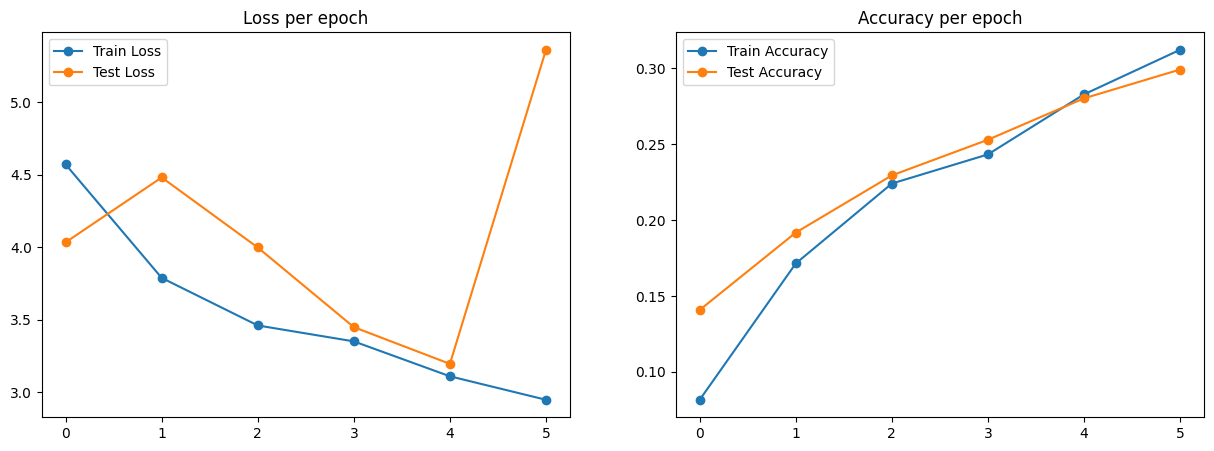

Validation loss didn't improve

 		 ------------------------------ EPOCH: 7 ------------------------------
[20:06:19] Step 20/704: train loss = 2.73661
[20:06:20] Step 40/704: train loss = 2.69548
[20:06:21] Step 60/704: train loss = 2.70397
[20:06:22] Step 80/704: train loss = 2.69749
[20:06:23] Step 100/704: train loss = 2.71565
[20:06:24] Step 120/704: train loss = 2.71769
[20:06:25] Step 140/704: train loss = 2.72933
[20:06:26] Step 160/704: train loss = 2.73952
[20:06:27] Step 180/704: train loss = 2.74958
[20:06:28] Step 200/704: train loss = 2.75508
[20:06:29] Step 220/704: train loss = 2.7609
[20:06:30] Step 240/704: train loss = 2.76544
[20:06:31] Step 260/704: train loss = 2.77312
[20:06:32] Step 280/704: train loss = 2.77535
[20:06:33] Step 300/704: train loss = 2.77515
[20:06:34] Step 320/704: train loss = 2.78067
[20:06:35] Step 340/704: train loss = 2.78547
[20:06:36] Step 360/704: train loss = 2.78764
[20:06:37] Step 380/704: train loss = 2.78643
[20:06:38] Step 400/704:

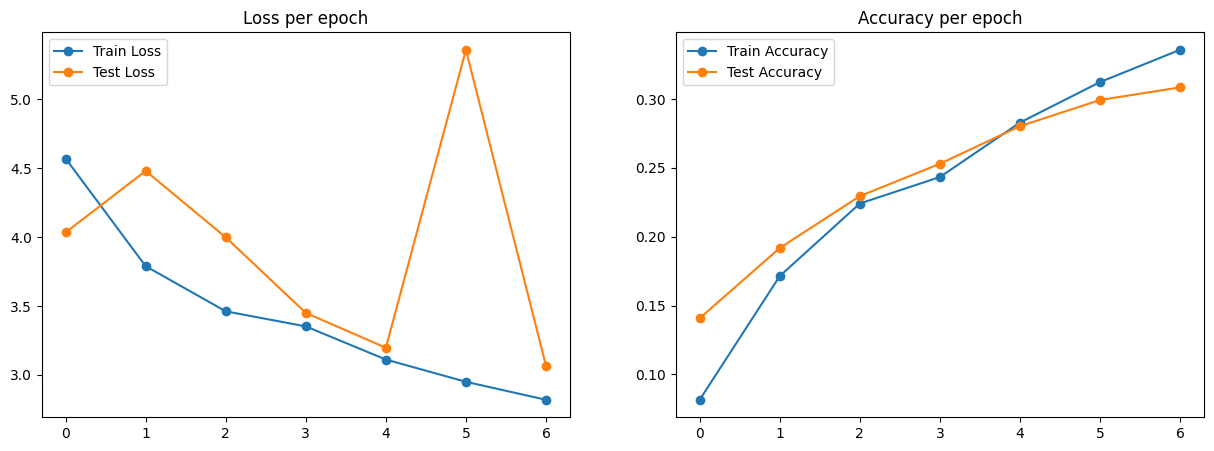

Saving best model

 		 ------------------------------ EPOCH: 8 ------------------------------
[20:06:58] Step 20/704: train loss = 2.72992
[20:06:59] Step 40/704: train loss = 2.63813
[20:07:00] Step 60/704: train loss = 2.65676
[20:07:01] Step 80/704: train loss = 2.64442
[20:07:02] Step 100/704: train loss = 2.6396
[20:07:03] Step 120/704: train loss = 2.64925
[20:07:04] Step 140/704: train loss = 2.64664
[20:07:05] Step 160/704: train loss = 2.6383
[20:07:06] Step 180/704: train loss = 2.64692
[20:07:07] Step 200/704: train loss = 2.65054
[20:07:08] Step 220/704: train loss = 2.66358
[20:07:09] Step 240/704: train loss = 2.66633
[20:07:10] Step 260/704: train loss = 2.66603
[20:07:11] Step 280/704: train loss = 2.6647
[20:07:12] Step 300/704: train loss = 2.66304
[20:07:13] Step 320/704: train loss = 2.66515
[20:07:14] Step 340/704: train loss = 2.66663
[20:07:16] Step 360/704: train loss = 2.67116
[20:07:17] Step 380/704: train loss = 2.67514
[20:07:18] Step 400/704: train loss = 2

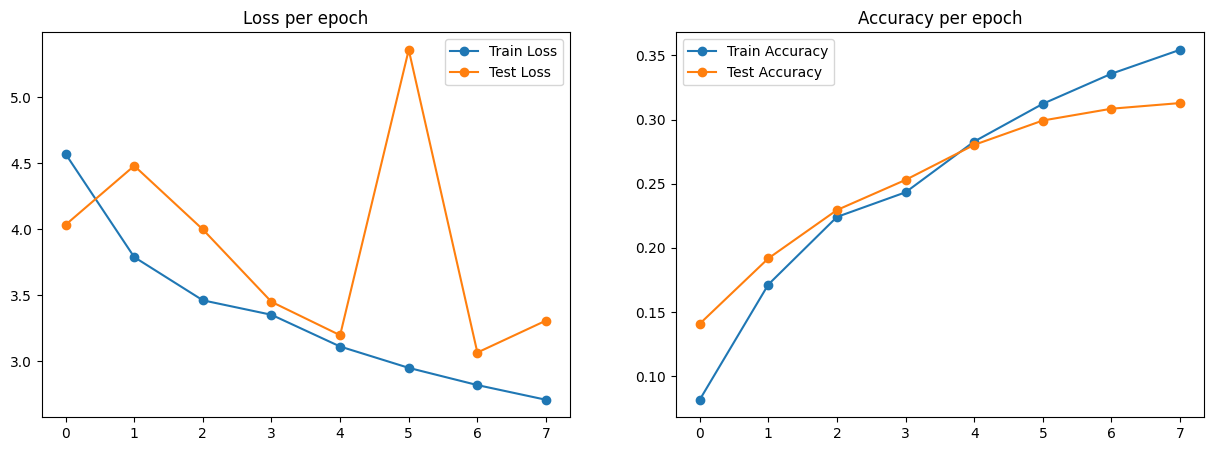

Validation loss didn't improve

 		 ------------------------------ EPOCH: 9 ------------------------------
[20:07:38] Step 20/704: train loss = 2.50294
[20:07:39] Step 40/704: train loss = 2.44938
[20:07:40] Step 60/704: train loss = 2.46072
[20:07:41] Step 80/704: train loss = 2.48097
[20:07:42] Step 100/704: train loss = 2.47312
[20:07:43] Step 120/704: train loss = 2.48095
[20:07:44] Step 140/704: train loss = 2.48578
[20:07:45] Step 160/704: train loss = 2.48788
[20:07:46] Step 180/704: train loss = 2.49746
[20:07:47] Step 200/704: train loss = 2.50216
[20:07:48] Step 220/704: train loss = 2.51005
[20:07:49] Step 240/704: train loss = 2.52306
[20:07:50] Step 260/704: train loss = 2.52801
[20:07:51] Step 280/704: train loss = 2.53489
[20:07:52] Step 300/704: train loss = 2.53812
[20:07:53] Step 320/704: train loss = 2.53996
[20:07:54] Step 340/704: train loss = 2.54151
[20:07:55] Step 360/704: train loss = 2.54533
[20:07:56] Step 380/704: train loss = 2.5512
[20:07:57] Step 400/704:

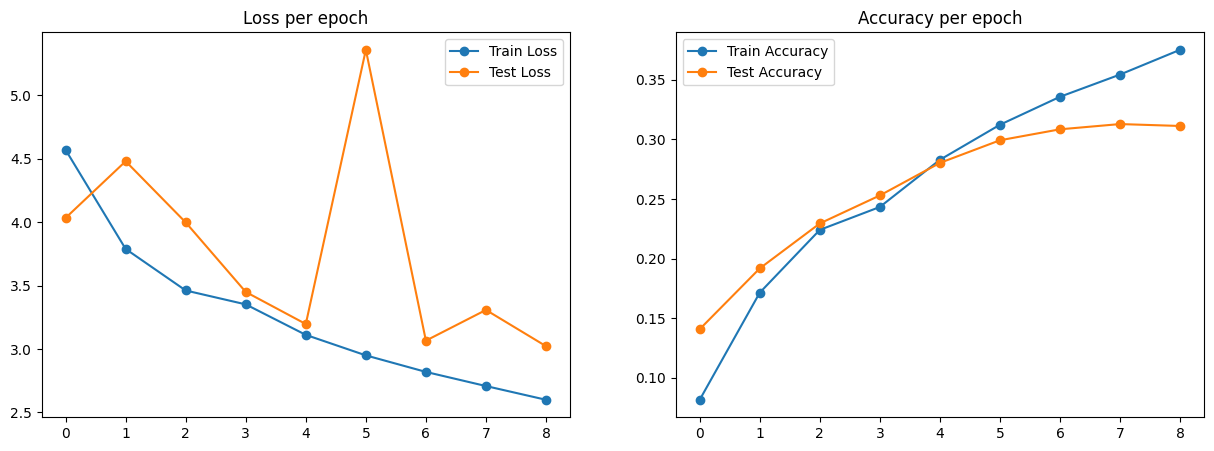

Saving best model

 		 ------------------------------ EPOCH: 10 ------------------------------
[20:08:17] Step 20/704: train loss = 2.56686
[20:08:18] Step 40/704: train loss = 2.49485
[20:08:19] Step 60/704: train loss = 2.45998
[20:08:20] Step 80/704: train loss = 2.44612
[20:08:21] Step 100/704: train loss = 2.43899
[20:08:22] Step 120/704: train loss = 2.43894
[20:08:23] Step 140/704: train loss = 2.43438
[20:08:24] Step 160/704: train loss = 2.42662
[20:08:25] Step 180/704: train loss = 2.43203
[20:08:26] Step 200/704: train loss = 2.43146
[20:08:28] Step 220/704: train loss = 2.42669
[20:08:29] Step 240/704: train loss = 2.43468
[20:08:30] Step 260/704: train loss = 2.43711
[20:08:31] Step 280/704: train loss = 2.44893
[20:08:32] Step 300/704: train loss = 2.45383
[20:08:33] Step 320/704: train loss = 2.45684
[20:08:34] Step 340/704: train loss = 2.45759
[20:08:35] Step 360/704: train loss = 2.46181
[20:08:36] Step 380/704: train loss = 2.46417
[20:08:37] Step 400/704: train loss

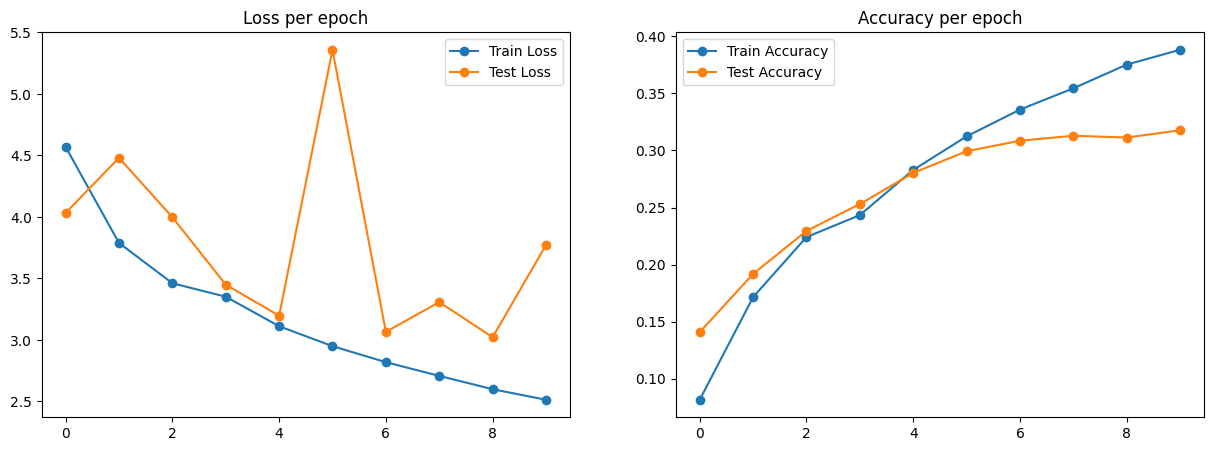

Validation loss didn't improve

 		 ------------------------------ EPOCH: 11 ------------------------------
[20:08:57] Step 20/704: train loss = 2.29569
[20:08:58] Step 40/704: train loss = 2.29036
[20:08:59] Step 60/704: train loss = 2.30565
[20:09:00] Step 80/704: train loss = 2.30496
[20:09:01] Step 100/704: train loss = 2.29777
[20:09:02] Step 120/704: train loss = 2.30214
[20:09:03] Step 140/704: train loss = 2.31417
[20:09:04] Step 160/704: train loss = 2.32064
[20:09:05] Step 180/704: train loss = 2.32426
[20:09:06] Step 200/704: train loss = 2.32146
[20:09:07] Step 220/704: train loss = 2.32893
[20:09:08] Step 240/704: train loss = 2.33282
[20:09:09] Step 260/704: train loss = 2.33231
[20:09:10] Step 280/704: train loss = 2.33869
[20:09:11] Step 300/704: train loss = 2.34605
[20:09:12] Step 320/704: train loss = 2.34969
[20:09:13] Step 340/704: train loss = 2.3552
[20:09:14] Step 360/704: train loss = 2.35974
[20:09:15] Step 380/704: train loss = 2.36811
[20:09:16] Step 400/704

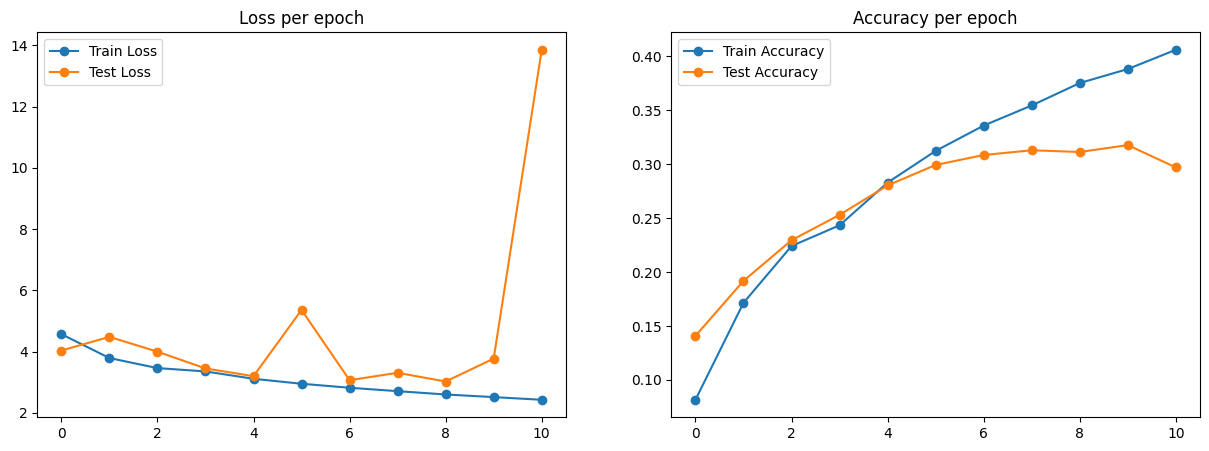

Validation loss didn't improve
EARLY STOPPING: min test_loss 3.0223, last 2 epochs min: 3.77166
Restoring the model at epoch 8: test_accuracy = 0.3113
Model successfully restored

 Training time: 7.0 minutes 13.438953649252653 seconds

 Final model is stored to model_epoch_8_test_acc_0.3113.pth


In [57]:
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
    
}
t1 = monotonic()
for epoch in range(train_config['n_epochs']):
    print('\n', '\t\t', '-' * 30, f"EPOCH: {epoch + 1}", '-' * 30)

    # Train
    model.train()
    model.to(DEVICE)
    train_avg_loss, train_accuracy = do_train_epoch(model, 
                                                    criterion, 
                                                    optimizer, 
                                                    train_dataloader, 
                                                    verbose=20)

    history['train_loss'].append(train_avg_loss)
    history['train_accuracy'].append(train_accuracy)

    # Val
    model.eval()
    val_avg_loss, val_accuracy = do_val_epoch(model, 
                                              criterion, 
                                              val_dataloader)
    history['test_loss'].append(val_avg_loss)
    history['test_accuracy'].append(val_accuracy)

    # on_epoch_end events
    plot_history(history)
    
    # model checkpointing
    if history['test_loss'][-1] == min(history['test_loss']):
        print('Saving best model')
        torch.save(model.state_dict(), best_checkpoint_path)
    else:
        print("Validation loss didn't improve")

    # early stopping
    if min(history['test_loss'][-2:]) > min(history['test_loss']):
        best_epoch = np.argmin(history['test_loss'])
        best_test_accuracy = history['test_accuracy'][best_epoch]

        print(f'EARLY STOPPING: min test_loss {min(history["test_loss"])}, last 2 epochs min: {min(history["test_loss"][-2:])}')
        print(f'Restoring the model at epoch {best_epoch}: test_accuracy = {best_test_accuracy}')

        model.load_state_dict(torch.load(best_checkpoint_path, weights_only=True))
        print('Model successfully restored')
        break
t2 = monotonic()
m, s = divmod(t2 - t1, 60)
    # lr_adjustments (todo)


# saving the best model to hard storage
model_file_name = f'model_epoch_{best_epoch}_test_acc_{best_test_accuracy}.pth'
torch.save(model.state_dict(), f'../working/{model_file_name}')

print(f'\n Training time: {m} minutes {s} seconds')
print(f'\n Final model is stored to {model_file_name}')
os.remove(best_checkpoint_path)

### Make a prediction and prepare submission file

In [58]:
import pandas as pd

In [59]:
class TestDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 file_names: list[str],
                 transform=None):
        self.img_dir = img_dir
        self.file_names = file_names
        self.image_ids = [int(n.split('.')[0].split('_')[1]) for n in file_names]
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path).convert('RGB')

        img_id = self.image_ids[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, img_id

In [60]:
test_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/val'
test_image_names = sorted(os.listdir(f'{test_folder}/images'))
len(test_image_names)

10000

In [61]:
test_dataset = TestDataset(f'{test_folder}/images', test_image_names, transform=val_img_transform)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128)

In [62]:
model.eval()

test_predictions = pd.Series([-1] * len(test_dataset))

total_steps = len(test_dataloader)
step = 0

with torch.no_grad():
    for X, img_ids in test_dataloader:
        preds = model(X.to(DEVICE)).cpu()
        
        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        # predicted_labels = torch.tensor([0] * X.shape[0])

        test_predictions.loc[img_ids] = predicted_labels.numpy()
        step += 1

        if step % 10 == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps} done")

[20:09:36] Step 10/79 done


[20:09:36] Step 20/79 done
[20:09:37] Step 30/79 done
[20:09:37] Step 40/79 done
[20:09:38] Step 50/79 done
[20:09:38] Step 60/79 done
[20:09:39] Step 70/79 done


In [63]:
test_predictions_df = (test_predictions
                       .reset_index()
                       .rename(columns={'index': 'ID', 0: 'class'}))
test_predictions_df.head()

,ID,class
0,0,62
1,1,135
2,2,66
3,3,142
4,4,92


In [64]:
# here we will do some analysis to ensure predictions file looks reasonable
(test_predictions_df['class'] < 0).sum()

np.int64(0)

In [65]:
test_predictions_df['class'].value_counts()

class
125    143
64     134
69     122
4      122
60     118
      ... 
118     10
199      9
30       7
164      7
198      6
Name: count, Length: 200, dtype: int64

In [66]:
test_predictions_df['class'] = test_predictions_df['class'].map(class_id_to_name_dict)
test_predictions_df['ID'] = test_predictions_df['ID'].apply(lambda v: f'val_{v}.JPEG')

In [67]:
test_predictions_df.head()

,ID,class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n01784675
2,val_2.JPEG,n03014705
3,val_3.JPEG,n02808440
4,val_4.JPEG,n04099969


In [68]:
test_predictions_df.to_csv(f'../working/submission_{model_file_name}.csv', index=False)